In [15]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
OUTPUT_PATH = "/Volumes/GoogleDrive/Meine Ablage/Dokumente/1 - Schule/1 - ETHZ/9. Semester/Master Thesis/thesis/img"

In [16]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":14,
                                "axes.labelsize":14})

In [17]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

In [18]:
def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                all_deltas = [fin_time - data['producer'][file_size][run_number]['uploadTime'] for fin_time in all_finished_times]
                deltas[file_size][run_number] = all_deltas
    return deltas

In [38]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

# S3

In [19]:
S3_BASE_PATH = os.path.join(BASE_PATH, "s3")

## P2P

### Variance

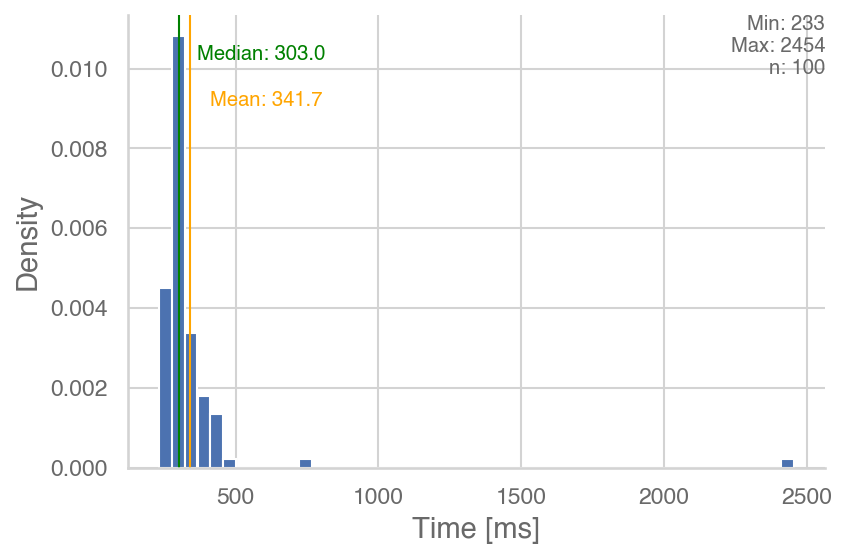

In [20]:
var_base_path = os.path.join(S3_BASE_PATH, "p2p", "latency_distribution", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
delta_vals = list(deltas[10000000].values())
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50)
plt.xlabel("Time [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.savefig(os.path.join(OUTPUT_PATH, "s3_p2p_variance.pdf"))
plt.show()

### Performance

{0.001: 2.666666666666667e-05, 1.0: 0.02127659574468085, 10.0: 0.2564102564102564, 100.0: 2.197802197802198, 1000.0: 9.174311926605503, 10000.0: 37.17472118959108, 100000.0: 53.951982735365526, 500000.0: 45.674614049511284}


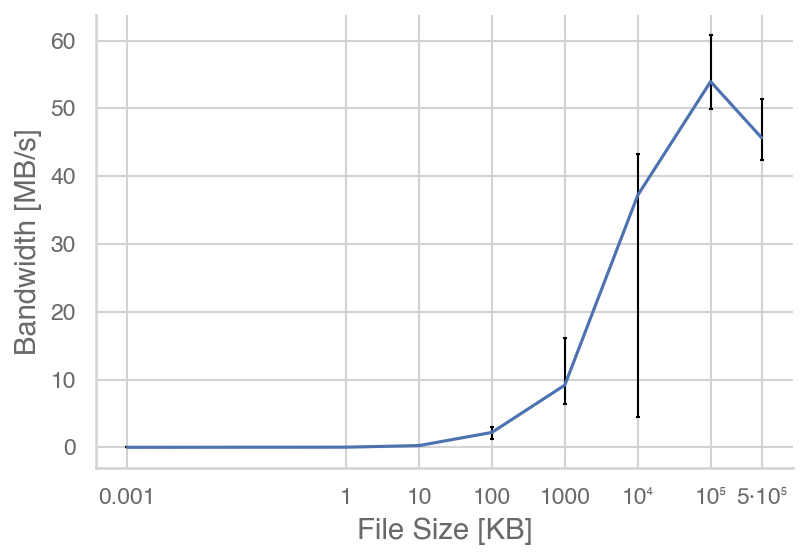

{0.001: 37.5, 1.0: 47.0, 10.0: 39.0, 100.0: 45.5, 1000.0: 109.0, 10000.0: 269.0, 100000.0: 1853.5, 500000.0: 10947.0}


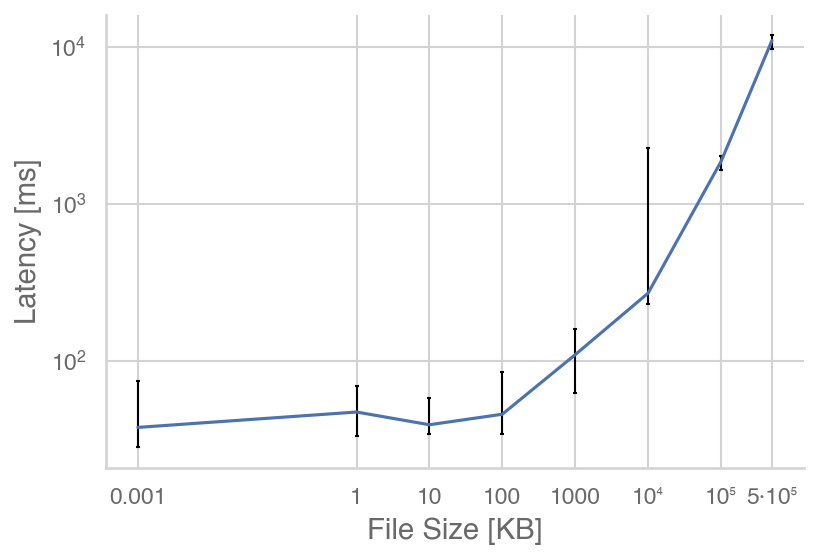

In [40]:
var_base_path = os.path.join(S3_BASE_PATH, "p2p", "scaling", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    val = file_size / np.median(values) / 1000
    plot_data[file_size / 1000] = val
    upper_ci = file_size / np.min(values) / 1000 - val
    lower_ci = val - file_size / np.max(values) / 1000
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()), format_xticks(plot_data.keys()))
plt.ylabel("Bandwidth [MB/s]")
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_p2p_bandwidth.pdf"))
plt.show()
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    val = np.median(values)
    plot_data[file_size / 1000] = val
    upper_ci = np.max(values) - val
    lower_ci = val - np.min(values)
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()), format_xticks(plot_data.keys()))
plt.ylabel("Latency [ms]")
plt.yscale('log')
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_p2p_latency.pdf"))
plt.show()

## One to Many

### Variance

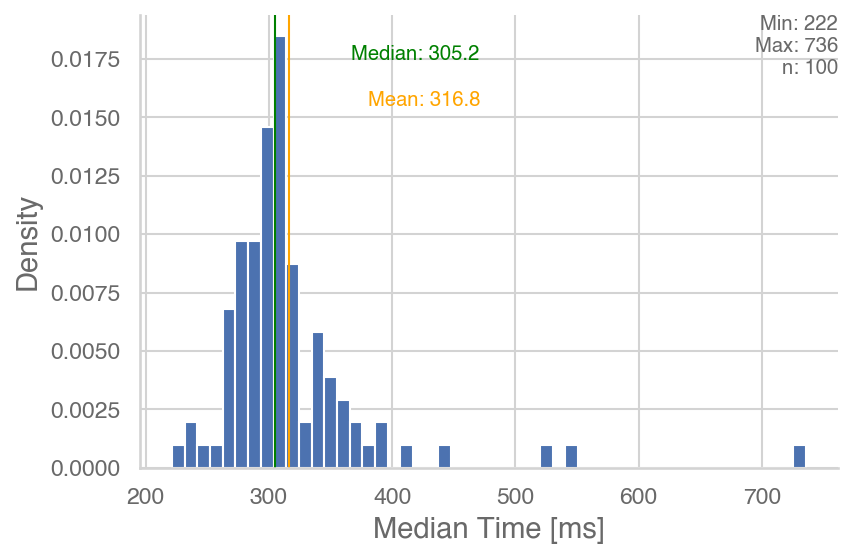

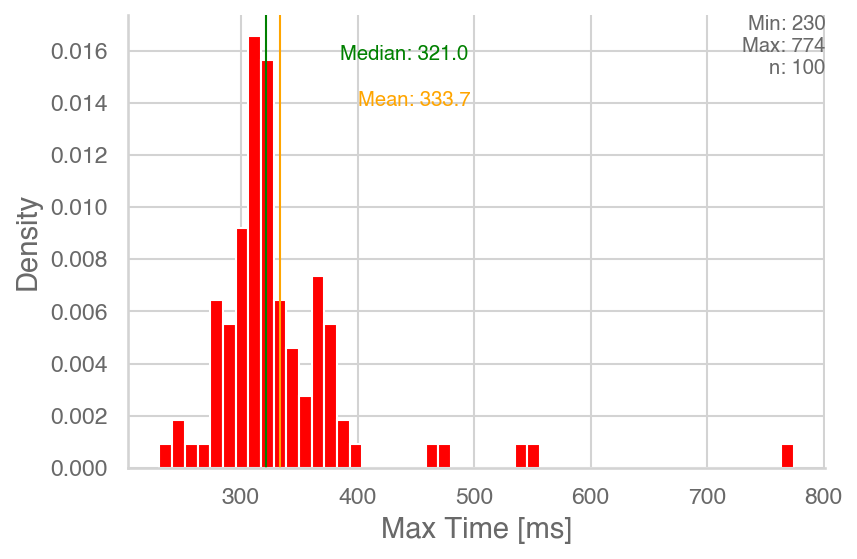

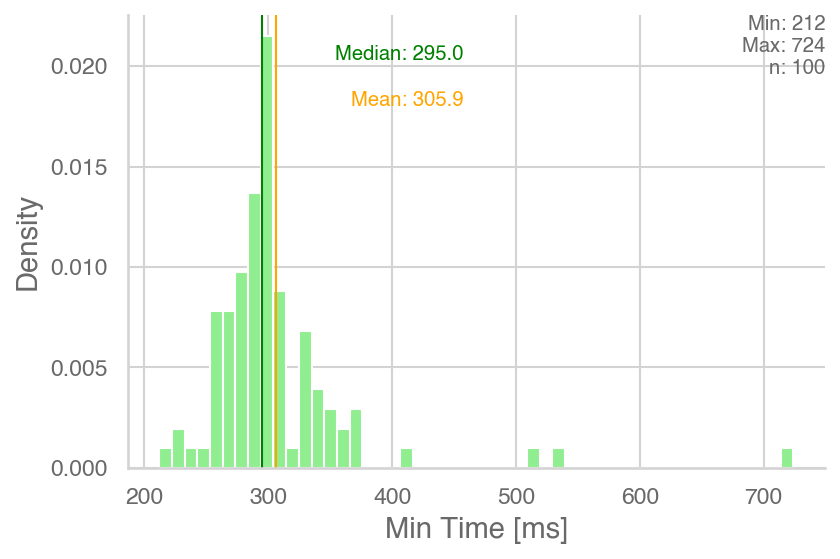

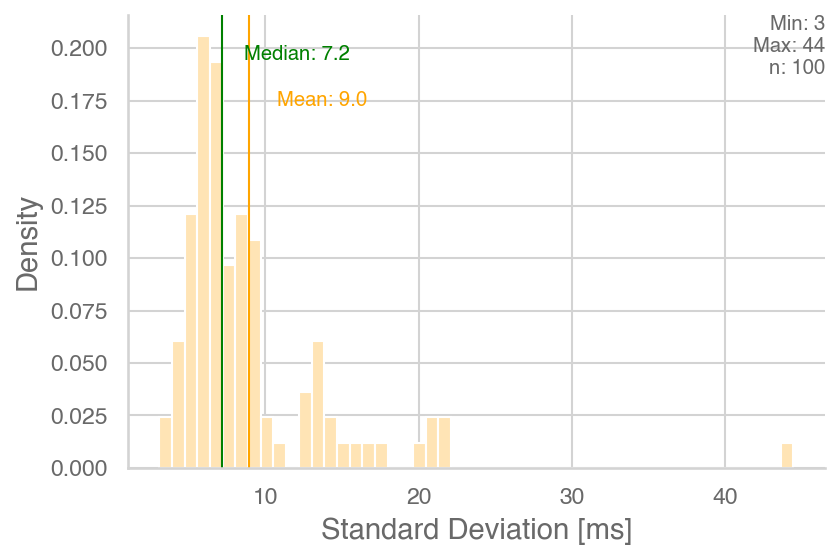

In [22]:
var_base_path = os.path.join(S3_BASE_PATH, "one_to_many", "latency_distribution", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
all_delta_vals = list(deltas[10000000].values())
delta_vals = [np.median(run_vals) for run_vals in all_delta_vals]
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50)
plt.xlabel("Median Time [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.savefig(os.path.join(OUTPUT_PATH, "s3_one-to-many_variance_median.pdf"))
plt.show()
delta_vals = [np.max(run_vals) for run_vals in all_delta_vals]
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50, color="red")
plt.xlabel("Max Time [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.savefig(os.path.join(OUTPUT_PATH, "s3_one-to-many_variance_max.pdf"))
plt.show()
delta_vals = [np.min(run_vals) for run_vals in all_delta_vals]
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50, color="lightgreen")
plt.xlabel("Min Time [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.savefig(os.path.join(OUTPUT_PATH, "s3_one-to-many_variance_min.pdf"))
plt.show()
delta_vals = [np.std(run_vals) for run_vals in all_delta_vals]
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50, color="moccasin")
plt.xlabel("Standard Deviation [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.savefig(os.path.join(OUTPUT_PATH, "s3_one-to-many_variance_std.pdf"))
plt.show()

### Performance

{0.001: 0.00014434711558346678, 1.0: 0.13532599535369988, 10.0: 1.191443591869405, 100.0: 10.575824189852423, 1000.0: 55.06279242712807, 10000.0: 252.7851984306678, 100000.0: 431.90703292411155, 500000.0: 385.97968692993265}


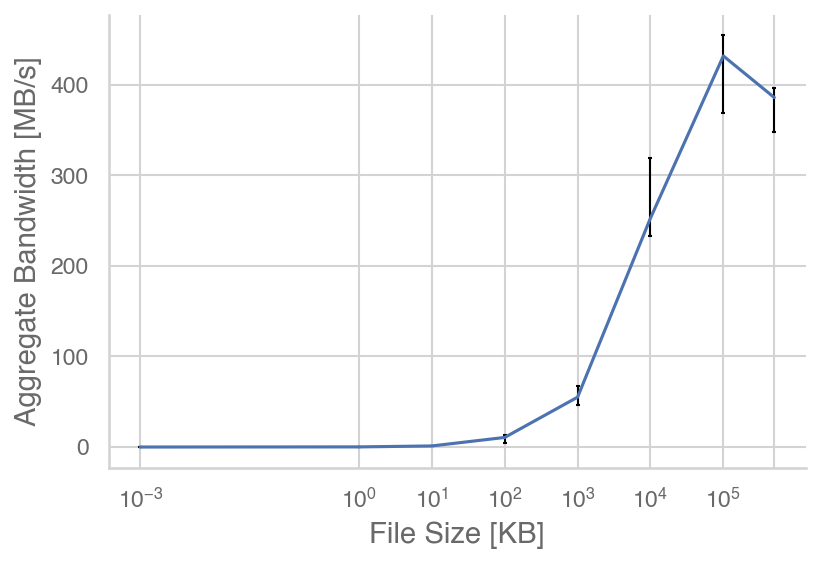

{0.001: 62.0, 1.0: 65.5, 10.0: 81.0, 100.0: 81.5, 1000.0: 157.5, 10000.0: 323.0, 100000.0: 1930.0, 500000.0: 10920.5}


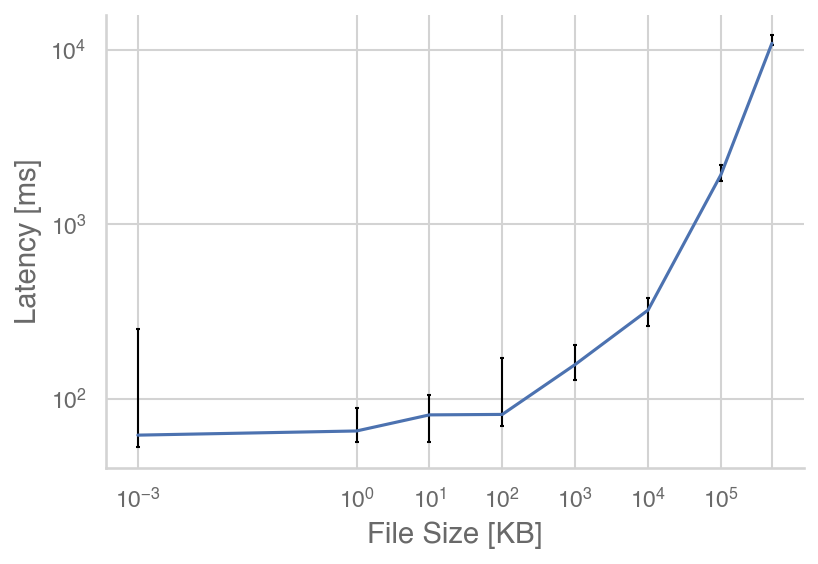

In [23]:
var_base_path = os.path.join(S3_BASE_PATH, "one_to_many", "scaling_data", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    agg_bandwidths = []
    for run_arr in values:
        agg_bandwidth = 0
        for latency in run_arr:
            agg_bandwidth += file_size / latency / 1000
        agg_bandwidths.append(agg_bandwidth)
    val = np.median(agg_bandwidths)
    plot_data[file_size / 1000] = val
    upper_ci = np.max(agg_bandwidths) - val
    lower_ci = val - np.min(agg_bandwidths)
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()), format_xticks(plot_data.keys()))
plt.ylabel("Aggregate Bandwidth [MB/s]")
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_one-to-many_bandwidth.pdf"))
plt.show()
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    run_latencies = []
    for run_arr in values:
        run_latencies.append(np.max(run_arr))
    val = np.median(run_latencies)
    plot_data[file_size / 1000] = val
    upper_ci = np.max(run_latencies) - val
    lower_ci = val - np.min(run_latencies)
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()), format_xticks(plot_data.keys()))
plt.ylabel("Latency [ms]")
plt.yscale('log')
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_one-to-many_latency.pdf"))
plt.show()

### Scalability

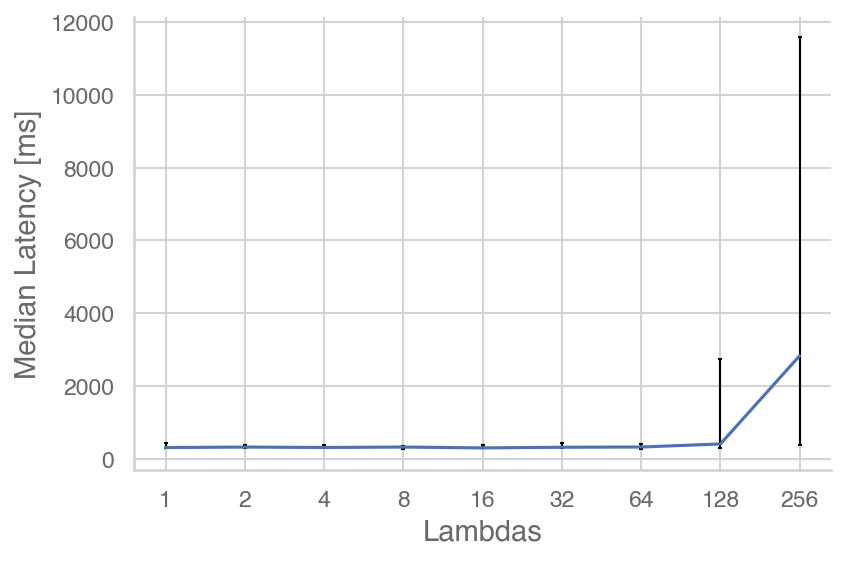

In [24]:
experiment_base_folder = os.path.join(S3_BASE_PATH, "one_to_many", "scaling_lambdas", "out")
plot_data = {}
lower_error = []
upper_error = []
num_lambdas = []
for subf in os.scandir(experiment_base_folder):
    num_lambdas.append(int(subf.name))
for num_lambda in sorted(num_lambdas):    
    var_base_path = os.path.join(S3_BASE_PATH, "one_to_many", "scaling_lambdas", "out", str(num_lambda))
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    run_medians = [np.median(run_data) for run_data in deltas[10000000].values()]
    plot_data[num_lambda] = np.median(run_medians)
    lower_error.append(np.median(run_medians) - np.min(run_medians))
    upper_error.append(np.max(run_medians) - np.median(run_medians))
plt.xscale('log')
plt.xlabel("Lambdas")
plt.xticks(list(plot_data.keys()))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel("Median Latency [ms]")
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_one-to-many_scalability.pdf"))
plt.show()

# ElastiCache Redis

In [25]:
REDIS_BASE_PATH = os.path.join(BASE_PATH, "redis")

## P2P

### Variance

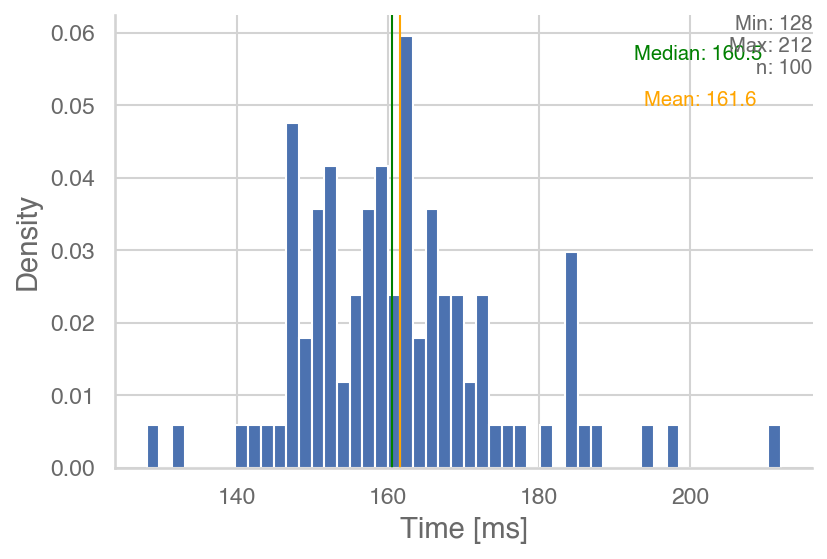

In [26]:
var_base_path = os.path.join(REDIS_BASE_PATH, "p2p", "latency_distribution", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
delta_vals = list(deltas[10000000].values())
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50)
plt.xlabel("Time [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.savefig(os.path.join(OUTPUT_PATH, "redis_p2p_variance.pdf"))
plt.show()

### Performance

{0.001: 0.0005, 1.0: 0.6666666666666666, 10.0: 4.0, 100.0: 8.333333333333334, 1000.0: 19.801980198019802, 10000.0: 52.35602094240838, 100000.0: 96.15384615384616, 500000.0: 46.4921660700172}


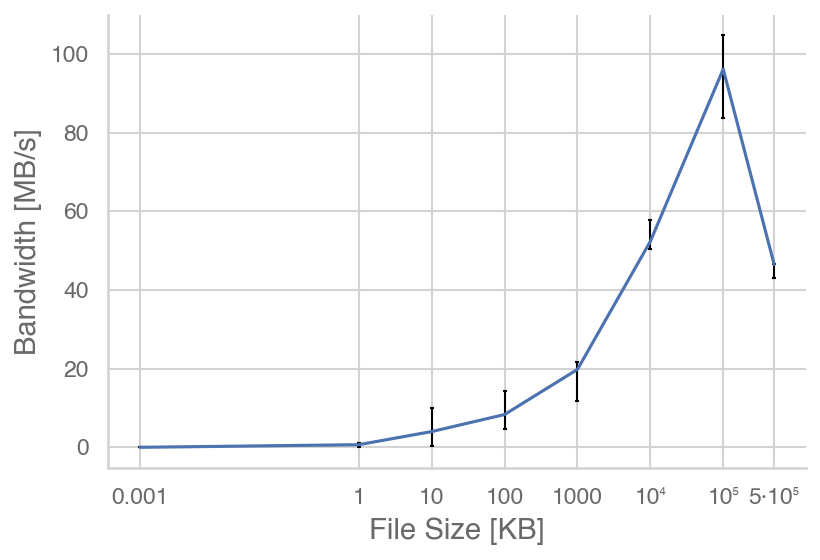

{0.001: 2.0, 1.0: 1.5, 10.0: 2.5, 100.0: 12.0, 1000.0: 50.5, 10000.0: 191.0, 100000.0: 1040.0, 500000.0: 10754.5}


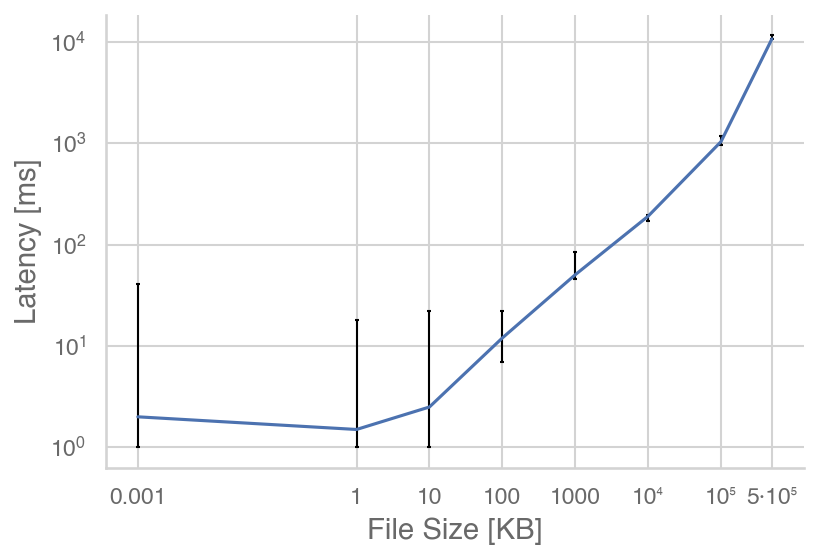

In [42]:
var_base_path = os.path.join(REDIS_BASE_PATH, "p2p", "scaling", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    val = file_size / np.median(values) / 1000
    plot_data[file_size / 1000] = val
    upper_ci = file_size / np.min(values) / 1000 - val
    lower_ci = val - file_size / np.max(values) / 1000
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()), format_xticks(plot_data.keys()))
plt.ylabel("Bandwidth [MB/s]")
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "redis_p2p_bandwidth.pdf"))
plt.show()
plot_data = {}
lower_error = []
upper_error = []
for file_size in sorted(deltas):
    values = list(deltas[file_size].values())
    val = np.median(values)
    plot_data[file_size / 1000] = val
    upper_ci = np.max(values) - val
    lower_ci = val - np.min(values)
    lower_error.append(lower_ci)
    upper_error.append(upper_ci)
print(plot_data)
plt.xscale('log')
plt.xlabel("File Size [KB]")
plt.xticks(list(plot_data.keys()), format_xticks(plot_data.keys()))
plt.ylabel("Latency [ms]")
plt.yscale('log')
plt.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], ecolor='black', elinewidth=1, capsize=1)
plt.savefig(os.path.join(OUTPUT_PATH, "s3_p2p_latency.pdf"))
plt.show()